In [89]:
# Leaky integrator model of Echo State Network
import numpy as np
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
% matplotlib inline

In [493]:
N_NODES = 200
SPECT_RADIUS = 0.9

a = 1
time_scale = np.ones(N_NODES)*a
trainlen = 5000
future = 1000
buffer = 100

In [494]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x

def step_function(x):
    if x > 0.5:
        return 1
    else:
        return 0
    
def sigmoid(x):
    return 1/(1+np.exp(-10*x+1))


class LI_ESN_internal:

    def __init__(self, n_inputs, n_outputs, n_reservoir=200, W=None, W_in=None,
                 noise=0.001, input_shift=None,
                 input_scaling=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, time_scale=None):
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        self.time_scale = time_scale
        self.W = W
        self.W_in = W_in

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand
            
    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _update(self, state, input_pattern):
        # leaky integrator model:
        # it can adjust timescales for each neurons.
        preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        # state = (1 - self.time_scale) * state + self.time_scale * np.tanh(preactivation)
        state = (1 - self.time_scale) * state + self.time_scale * sigmoid(preactivation)
        return (state + self.noise * self.time_scale * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def calc_lyapunov_exp(self, inputs, initial_distance, n):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        states1 = np.zeros((inputs.shape[0], self.n_reservoir))
        states2 = np.zeros((inputs.shape[0], self.n_reservoir))
        transient = min(int(inputs.shape[0] / 10), 100)
        for i in range(1, transient):
            states1[i, :] = self._update(states1[i-1], inputs[i, :])
        states2[transient-1, :] = states1[transient-1, :]
        states2[transient-1, n] = states2[transient-1, n] + initial_distance
        gamma_k_list = []
        for k in range(transient, inputs.shape[0]):
            states1[k, :] = self._update(states1[k-1], inputs[k, :])
            states2[k, :] = self._update(states2[k-1], inputs[k, :])
            gamma_k = np.linalg.norm(states2[k, :]-states1[k, :])
            gamma_k_list.append(gamma_k/initial_distance)
            states2[k, :] = states1[k, :] + (initial_distance/gamma_k)*(states2[k, :]-states1[k, :])
        lyapunov_exp = np.mean(np.log(gamma_k_list))
        return lyapunov_exp
            
    
    def fit(self, inputs, outputs):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = outputs

        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :])
        transient = min(int(inputs.shape[0] / 10), 100)
        extended_states = np.hstack((states, inputs_scaled))
        
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),teachers_scaled[transient:, :]).T
        # print(self.W_out.shape)

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
            
        # apply learned weights to the collected states:
        pred_train = np.dot(extended_states, self.W_out.T)
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, inputs])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :])
            outputs[n + 1, :] = np.dot(self.W_out,np.concatenate([states[n + 1, :], inputs[n + 1, :]]))

        return self.out_activation(outputs[1:])
        # print(outputs[1:])
        # return np.heaviside(outputs[1:]-0.5, 0)*0.3


In [495]:
def memory_capacity(L, buffer, data, output_data):
    MC = 0
    for k in range(L):
        cov_matrix = np.cov(np.array([data[trainlen+buffer-(k+1): trainlen+buffer-(k+1)+1000],output_data.T[k]]))
        MC_k = cov_matrix[0][1]**2
        MC_k = MC_k / (np.var(data[trainlen+buffer:])*np.var(output_data.T[k]))
        MC += MC_k
    return MC

In [497]:
def make_modular_network(N, average_degree, community_number, mu):
    assert N % community_number == 0, 'N must be devisible by community_number'
    G = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            if j < (N/community_number)*(i//(N/community_number)+1):
                if np.random.rand() < ((N-(i/N))/N)*average_degree*(1-mu)/(N/community_number):
                    G[i][j] = -1 if np.random.rand()<0.5 else 1
                    G[j][i] = G[i][j]
            else:
                if np.random.rand() < ((N-(i/N))/N)*average_degree*(mu)/(N-(N/community_number)):
                    G[i][j] = -1 if np.random.rand()<0.5 else 1
                    G[j][i] = G[i][j]
    return G

In [512]:
W = make_modular_network(N_NODES, 6, 10, 0.05)
# print(W)
W_IN = (np.random.rand(N_NODES, 1) * 2 - 1)*0.1
W_IN[int(N_NODES/10):] = 0
W_tilda = (1-a)*np.eye(N_NODES) + a*W
radius = np.max(np.abs(np.linalg.eigvals(W)))
radius_tilda = np.max(np.abs(np.linalg.eigvals(W_tilda)))
# print(radius, radius_tilda)
spectral_radius = SPECT_RADIUS
W = W * (spectral_radius / radius)
W_tilda = (1-a)*np.eye(N_NODES) + a*W
# W_tilda = W_tilda * (spectral_radius / radius_tilda)
# W = (1/a)*(W_tilda - (1-a)*np.eye(N_NODES))
radius_tilda = np.max(np.abs(np.linalg.eigvals(W_tilda)))
# print(radius_tilda)

radius = np.max(np.abs(np.linalg.eigvals(W)))
# print(radius)

In [513]:
# delayed signal
L = int(N_NODES*2)
# L = 20

buffer = L
total_len = future + trainlen + buffer
tau = 0.3
data = [0 if np.random.rand() < 0.5 else 1 for i in range(total_len)]
data = np.array(data)*tau
# print(data)


esn = LI_ESN_internal(n_inputs=1,
                      n_outputs=L,
                      n_reservoir=N_NODES,
                      W=W,
                      W_in=W_IN,
                      noise=0,
                      time_scale=time_scale)


target = np.zeros((total_len - buffer, L))
for i in range(L):
    target.T[i][:] = data[buffer-(i+1):-(i+1)]

pred_training = esn.fit(data[buffer:trainlen+buffer], target[:trainlen])

prediction = esn.predict(data[trainlen+buffer:])
# print(prediction)

    
print(memory_capacity(L, buffer, data, prediction))


16.066924470509775


In [531]:
def calculate_memory_capacity(mu, r_sig, num_community):
    memory_capacity_list = []
    for k in range(30):
        W = make_modular_network(N_NODES, 6, num_community, mu)
        W_IN = (np.random.rand(N_NODES, 1) * 2 - 1)*0.1
        W_IN[int(N_NODES/num_community):] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        spectral_radius = SPECT_RADIUS
        W = W * (spectral_radius / radius)
    
        # delayed signal
        L = int(N_NODES*2)
        # L = 20

        buffer = L
        total_len = future + trainlen + buffer
        data = [0 if np.random.rand() < 0.5 else 1 for i in range(total_len)]
        data = np.array(data)*r_sig
        # print(data)


        esn = LI_ESN_internal(n_inputs=1,
                              n_outputs=L,
                              n_reservoir=N_NODES,
                              W=W,
                              W_in=W_IN,
                              noise=0,
                              time_scale=time_scale)


        target = np.zeros((total_len - buffer, L))
        for i in range(L):
            target.T[i][:] = data[buffer-(i+1):-(i+1)]

        pred_training = esn.fit(data[buffer:trainlen+buffer], target[:trainlen])

        prediction = esn.predict(data[trainlen+buffer:])
        # print(prediction)

        memory_capacity_result = memory_capacity(L, buffer, data, prediction)
        # print(memory_capacity_result)
        memory_capacity_list.append(memory_capacity_result)
    return np.mean(memory_capacity_list), mu

In [522]:
print(calculate_memory_capacity(mu=0.1, r_sig=0.3))

(17.87658956735819, 0.1)


In [523]:
print(calculate_memory_capacity(mu=0.2, r_sig=0.3))

(16.33234145602097, 0.2)


In [524]:
print(calculate_memory_capacity(mu=0.3, r_sig=0.3))

(16.06727919843778, 0.3)


In [525]:
print(calculate_memory_capacity(mu=0.4, r_sig=0.3))

(15.820831865344015, 0.4)


In [526]:
print(calculate_memory_capacity(mu=0.5, r_sig=0.3))

(15.689648423068425, 0.5)


In [527]:
print(calculate_memory_capacity(mu=0.05, r_sig=0.3))

(19.408685376343144, 0.05)


In [528]:
print(calculate_memory_capacity(mu=0.0, r_sig=0.3))

(6.235410022322047, 0.0)


In [529]:
print(calculate_memory_capacity(mu=0.02, r_sig=0.3))

(16.524389276565433, 0.02)


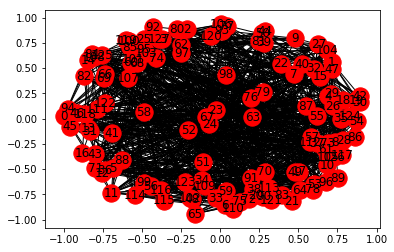

In [544]:
W = make_modular_network(128, 16, 4, 0.1)
G=nx.from_numpy_matrix(W)
nx.draw_networkx(G)

In [545]:
print(calculate_memory_capacity(mu=0.02, r_sig=0.3, num_community=4))

(18.6060247833929, 0.02)


In [546]:
print(calculate_memory_capacity(mu=0.2, r_sig=0.3, num_community=4))

(14.462078371997725, 0.2)


In [550]:
print(calculate_memory_capacity(mu=0.01, r_sig=0.3, num_community=4))

(19.02258679364742, 0.01)


In [553]:
print(calculate_memory_capacity(mu=0.001, r_sig=0.3, num_community=4))

(10.8589219545489, 0.001)
